feature engineering to prepare training data for XGBoost and logistic regression.
1. Build a switcher where I can turn on and off each feature engineering step. In the notebook. should I still build the feature engineering steps on top of each other? i.e. ohe on imputed df.
2. Outliers: We don't want to remove it, leaving them untouched for XGBoost. However, logistic regression is more sensitive to outliers, so we need to handle it.
3. Missing values: XGBoost is good at dealing missing values. However, missing values are still imputed to prepare for other algorithm and compare model performance. 
4. Scaling: scale the data with robust scaler because there are significant outliers, still scaling is not very helpful for xgboost but we add it case we are trying other algorithms.
5. Mutual information evaluation after all the preprocessing to find significant input features. 
6. Build a base model evalution for the dataset, which is evaluated by recall@5% because it's highly imbalanced. 

# 1. Setup

In [1]:
print("Starting setups")
import sys
import os

Starting setups


In [2]:
dir_path = os.getcwd()
parent_dir = os.path.dirname(dir_path)
home_dir = os.path.dirname(parent_dir)
print("dir_path is", dir_path)
print("parent_dir is", parent_dir)
print("home_dir is", home_dir)

dir_path is /Users/zoe/Documents/Bank-account-fraud/code/feature_engineering
parent_dir is /Users/zoe/Documents/Bank-account-fraud/code
home_dir is /Users/zoe/Documents/Bank-account-fraud


In [3]:
import yaml
print(home_dir+'/params.yaml')
with open(home_dir+'/params.yaml', 'r') as file:
    params = yaml.safe_load(file)
params

/Users/zoe/Documents/Bank-account-fraud/params.yaml


{'data_location': '/data',
 'output_location': '/output',
 'code_location': '/code'}

In [4]:
data_folder = home_dir+params['data_location']
print('Data is stored at', data_folder)

Data is stored at /Users/zoe/Documents/Bank-account-fraud/data


In [5]:
with open(dir_path+"/feature_flag.yaml", "r") as file:
    config = yaml.safe_load(file)["feature_engineering"]

print(f"Current configuration for feature engineering is: {config}")

Current configuration for feature engineering is: {'impute': True, 'one_hot_encoding': True, 'smote': True, 'smote_oversample_ratio': 0.8, 'smote_undersample_ratio': 1.0, 'robust_scaler': True, 'binning': True, 'outlier_handling': False, 'mutual_information': True, 'chi2_test': True}


## 1.1 Import libraries and reading data

In [6]:
print("Importing packages and reading data...")

sys.path.append(os.path.abspath("feature_engineering"))
from preprocessing import *

import pandas as pd
pd.set_option('display.max_columns', 500)

import warnings as wr
wr.filterwarnings('ignore')

Importing packages and reading data...


In [7]:
sys.path

['/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python311.zip',
 '/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11',
 '/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload',
 '',
 '/opt/homebrew/lib/python3.11/site-packages',
 '/Users/zoe/Documents/Bank-account-fraud/code/feature_engineering/feature_engineering']

In [8]:
df_base = pd.read_csv(f"{data_folder}/Base_backup.csv", header=0)
df = df_base.copy()

## 1.2 Drop features with no variance

In [9]:
constant_feature =[]
for x in df.columns:
    if df[x].nunique() == 1:
        constant_feature.append(x)
print("Dropping the constant features:", constant_feature)       
df = drop_columns(df, df[constant_feature])

Dropping the constant features: ['device_fraud_count']


### 1.3 Change the dataype of binary features into type boolean

In [10]:
print("Changing the dataype of binary features into type boolean")
binary_features = df.columns[df.nunique() == 2].tolist()

binary_features.remove('source')
# Convert these features"to boolean
df[binary_features] = df[binary_features].astype(bool)

# Verify changes
print(df[binary_features].dtypes)

Changing the dataype of binary features into type boolean
fraud_bool            bool
email_is_free         bool
phone_home_valid      bool
phone_mobile_valid    bool
has_other_cards       bool
foreign_request       bool
keep_alive_session    bool
dtype: object


## 1.3 Train test split

In [11]:
print("splitting train/test sets")
y = df['fraud_bool']
X = df.drop(columns=['fraud_bool'], axis = 1)

from sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print(f"Training set (X_train) before feature engineering: {X_train.shape}")
print(f"Test set (X_test) before feature engineering: {X_test.shape}")
print(f"Training set (y_train) before feature engineering: {y_train.shape}")
print(f"Test set (y_test) before feature engineering: {y_test.shape}")

categorical_features, numerical_features = split_num_cat(df)
print('Categorical features before feature engineering:', categorical_features)
print('Numerical features before feature engineering:', numerical_features)

splitting train/test sets
Training set (X_train) before feature engineering: (800000, 30)
Test set (X_test) before feature engineering: (200000, 30)
Training set (y_train) before feature engineering: (800000,)
Test set (y_test) before feature engineering: (200000,)
Categorical features before feature engineering: ['income', 'customer_age', 'payment_type', 'employment_status', 'email_is_free', 'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'month']
Numerical features before feature engineering: ['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'session_length_in_minutes']


## 2. Switcher

In [12]:
print("Start feature engineering steps...")

Start feature engineering steps...


In [13]:
if config["impute"]:
    print("Applying imputation for missing values...")
    X_train, X_test = impute_missing_values(X_train, X_test)
else:
    print("Not applying imputation.")

Applying imputation for missing values...
Features with missing values represented by -1:
['prev_address_months_count', 'current_address_months_count', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']
Train set null values after imputation:
prev_address_months_count       0
current_address_months_count    0
bank_months_count               0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64

Test set null values after imputation:
prev_address_months_count       0
current_address_months_count    0
bank_months_count               0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64
Training set shape after imputation: (800000, 32)
Test set shape after imputation: (200000, 32)


In [14]:
if config["one_hot_encoding"]:
    print("Applying one-hot encoding...")
    X_train, X_test = one_hot_encode(X_train, X_test)
else:
    print("Not applying one hot encoder.")

Applying one-hot encoding...
Categorical features to encode: ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
One-hot encoded training shape: (800000, 53)
One-hot encoded test shape: (200000, 53)


Applying binning...
the minimum value of bank_months_count is 0.0

 Bin Ranges:
Bin 1: [0.0, 1.0) -> Median: 0
Bin 2: [1.0, 5) -> Median: 2.5
Bin 3: [5, 9) -> Median: 6.5
Bin 4: [9, 13) -> Median: 10.5
Bin 5: [13, 17) -> Median: 14.5
Bin 6: [17, 21) -> Median: 18.5
Bin 7: [21, 25) -> Median: 22.5
Bin 8: [25, 29) -> Median: 26.5
Bin 9: [29, 33) -> Median: 30.5

 Bin medians and counts in training set:

bank_months_count_binned
0.0     202886
2.5     186125
6.5      37373
10.5     53539
14.5     51345
18.5     31604
22.5     30427
26.5    119801
30.5     86900
Name: count, dtype: int64


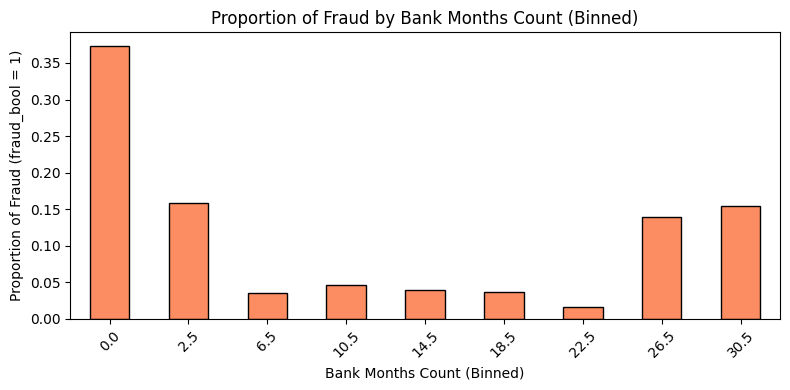

Final shape after binning - Train: (800000, 53), Test: (200000, 53)


In [15]:
if config["binning"]:
    print("Applying binning...")
    X_train, X_test = bin_bank_months_count(X_train, X_test, y_train)
else:
    print("Not applying binning.")

In [16]:
if config["robust_scaler"]:
    print("Applying robust scaling...")
    X_train, X_test = robust_scaler(X_train, X_test)
else:
    print("Not applying scaler.")

Applying robust scaling...
Categorical features: ['income', 'customer_age', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'keep_alive_session', 'device_distinct_emails_8w', 'month', 'bank_months_count_was_missing', 'prev_address_months_count_was_missing', 'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD', 'payment_type_AE', 'employment_status_CA', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'employment_status_CG', 'housing_status_BA', 'housing_status_BB', 'housing_status_BC', 'housing_status_BD', 'housing_status_BE', 'housing_status_BF', 'housing_status_BG', 'source_INTERNET', 'source_TELEAPP', 'device_os_linux', 'device_os_macintosh', 'device_os_other', 'device_os_windows', 'device_os_x11', 'bank_months_count_binned']
Numerical features: ['name_email_similarity', 'prev_address_months_count', 'current_address_mo

In [17]:
if config["outlier_handling"]:
    print("Removing outliers...")
    X_train, y_train = handle_outliers(X_train, y_train)
else:
    print("Not handling outliers")

Not handling outliers


In [19]:
if config["smote"]:
    print("Perfoming SMOTE to handle class imbalance")
    X_train, y_train = smote(X_train, y_train, over_ratio=config["smote_oversample_ratio"])
else:
    print("Not applying SMOTE")

Perfoming SMOTE to handle class imbalance
Before SMOTE: Counter({False: 791080, True: 8920})
Before SMOTE, shape of the training set: (800000, 53)


KeyboardInterrupt: 

In [1]:
import pickle

with open("processed_X_train.pkl", "wb") as f:
    pickle.dump(X_train, y_train, f)

In [169]:
X_train.nunique()

income                                           9
customer_age                                     9
email_is_free                                    2
phone_home_valid                                 2
phone_mobile_valid                               2
has_other_cards                                  2
proposed_credit_limit                           12
foreign_request                                  2
keep_alive_session                               2
device_distinct_emails_8w                        3
month                                            8
bank_months_count_was_missing                    2
prev_address_months_count_was_missing            2
payment_type_AA                                  2
payment_type_AB                                  2
payment_type_AC                                  2
payment_type_AD                                  2
payment_type_AE                                  2
employment_status_CA                             2
employment_status_CB           

Calculating mutual information scores based on the final training set
Mutual Information Scores:
housing_status_BA                          0.003505
device_os_windows                          0.003455
proposed_credit_limit                      0.003263
phone_home_valid                           0.002716
scaled_credit_risk_score                   0.002514
employment_status_CA                       0.002339
prev_address_months_count_was_missing      0.002013
device_os_other                            0.001896
device_os_linux                            0.001682
source_INTERNET                            0.001669
bank_months_count_binned                   0.001643
has_other_cards                            0.001622
scaled_date_of_birth_distinct_emails_4w    0.001598
scaled_current_address_months_count        0.001585
employment_status_CF                       0.001455
foreign_request                            0.001436
housing_status_BB                          0.001398
income             

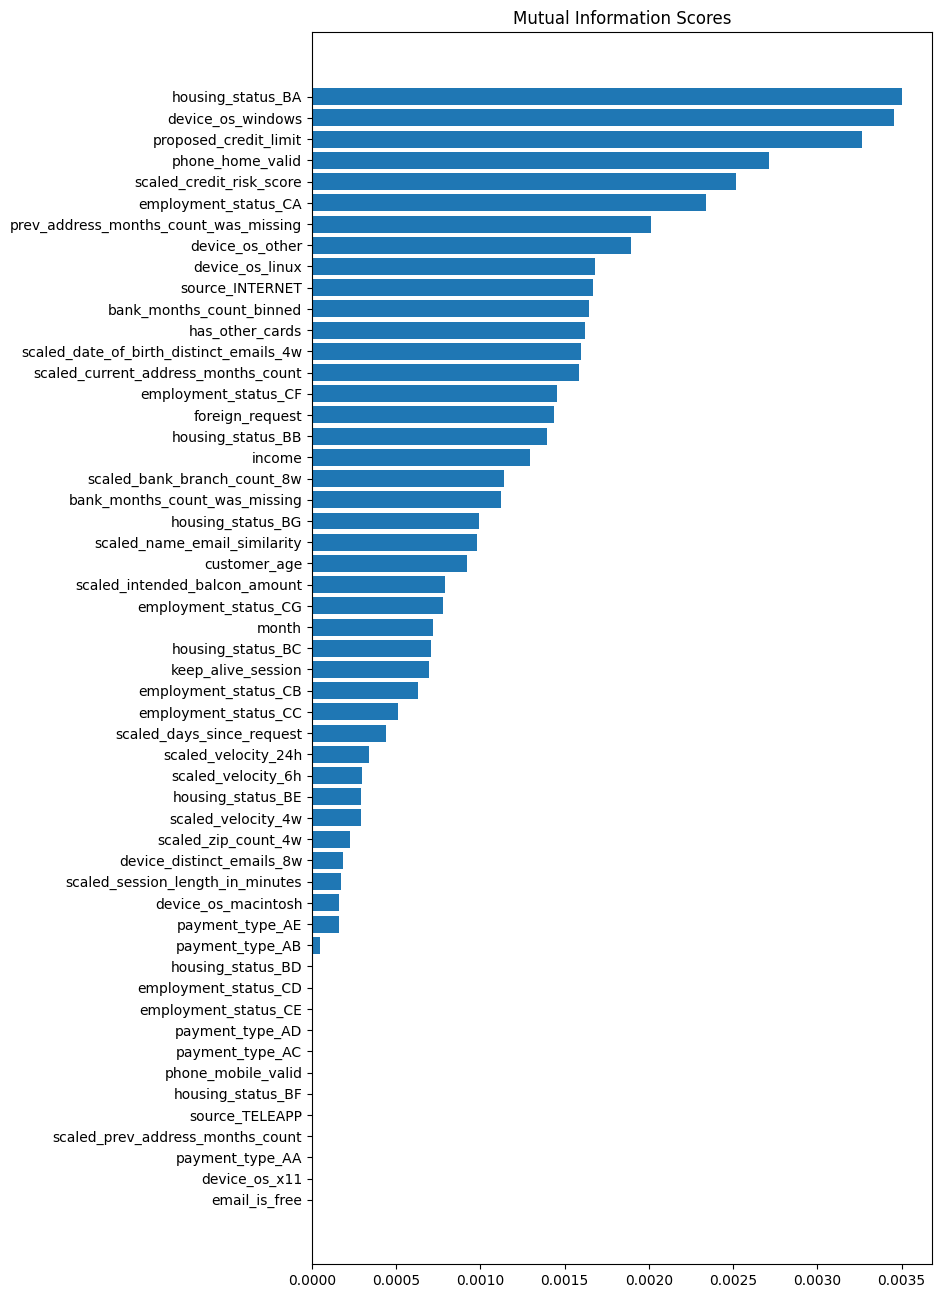

Calculating chi2 based on the final training set
Chi-Square Test Results:
                                  feature    chi2_score        p_value
1                            customer_age  1.386932e+04   0.000000e+00
25                      housing_status_BA  8.739463e+03   0.000000e+00
37                      device_os_windows  3.714831e+03   0.000000e+00
6                   proposed_credit_limit  1.770965e+06   0.000000e+00
8                      keep_alive_session  8.735908e+02  5.407087e-192
34                        device_os_linux  8.608609e+02  3.165200e-189
5                         has_other_cards  7.581747e+02  6.697868e-167
36                        device_os_other  7.212952e+02  6.998634e-159
29                      housing_status_BE  7.182984e+02  3.138047e-158
27                      housing_status_BC  6.564961e+02  8.636515e-145
13                        payment_type_AA  6.540571e+02  2.929354e-144
20                   employment_status_CC  6.035286e+02  2.859602e-133
15 

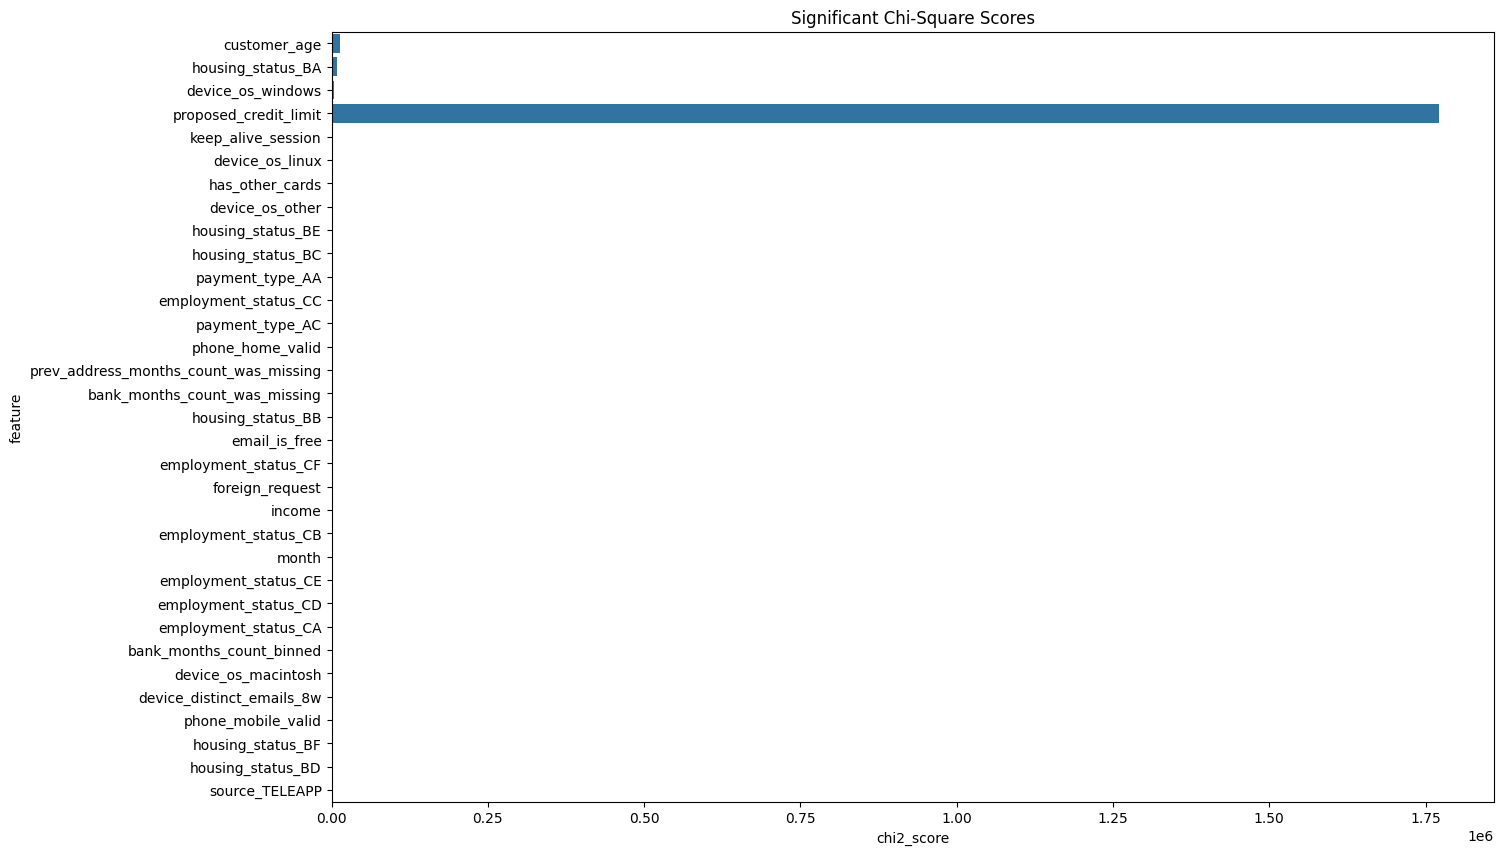

In [63]:
if config["mutual_information"]:
    print("Calculating mutual information scores based on the final training set")
    mi_scores = mutual_information(X_train, y_train)
else:
    print("Not calculating mutua information")
    
if config["chi2_test"]:
    print("Calculating chi2 based on the final training set")
    chi2_results = chi2_test(X_train, y_train)
else:
    print("Not calculating chi2")

# Save the final output 

In [ ]:
print("Exporting final dataset...")
export_final_df(X_train, y_train, X_test, y_test, data_folder)